In [1]:
import rebound
import time
import sys
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
from astropy import constants as c

# local imports
import heartbeat
import globs
import metasim

In [2]:
def run_sim(filestem='test/test'):
    
    # global variables

    globs.initialise()

    globs.glob_dclo = 1. #CE distance to check in rH
    #dir = 'test/'
    globs.glob_archive = ''
    #globals.glob_names = []
    globs.glob_is_close = False

    sys = metasim.MetaSim()
    sys.run_planets()
    if globs.glob_is_close:
        sys.rewind()
        sys.add_moons()
        sys.run_moons()
        sys.analyse()
        sys.make_timeline()

Simulation test/test0000.

Creating new simulation...
Running planets-only simulation...
CE between Planet1 and Planet2 with dist 0.009753843229031096 au at 7.979904060892049 years
<rebound.particle.Particle object at 0x7f8830f5fcc0, m=0.0019091884679386499 x=0.7413079388362698 y=1.5679388630485054 z=0.00438197206631002 vx=-3.802178724558032 vy=0.9694294368802566 vz=-2.6282884986453077>
<rebound.particle.Particle object at 0x7f8830f5fdc0, m=0.0019091884679386499 x=0.7378969040415462 y=1.5593301226013634 z=0.007446590685231821 vx=-4.244916356491805 vy=2.8609066601446145 vz=2.509899909117953>
CE between Planet2 and Planet1 with dist 0.009753843229031096 au at 7.979904060892049 years
<rebound.particle.Particle object at 0x7f8830f5fbc0, m=0.0019091884679386499 x=0.7378969040415462 y=1.5593301226013634 z=0.007446590685231821 vx=-4.244916356491805 vy=2.8609066601446145 vz=2.509899909117953>
<rebound.particle.Particle object at 0x7f8830f5fcc0, m=0.0019091884679386499 x=0.7413079388362698 y=1.

/Users/alexander/research/circumplanetary_discs/rebound/rebound/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


CE between Planet1 and Planet2 with dist 0.009705269744553949 au at 7.980026850146933 years
<rebound.particle.Particle object at 0x7f88116d3ac0, m=0.0019091884679386499 x=0.7404430337799673 y=1.568103400338655 z=0.004412899124584134 vx=-3.756857012432566 vy=0.9626910663238187 vz=-2.629707542360825>
<rebound.particle.Particle object at 0x7f88116d3a40, m=0.0019091884679386499 x=0.7370591540462398 y=1.5594971366267443 z=0.007358038116766371 vx=-4.293066313467534 vy=2.8634827570658103 vz=2.511175397748903>
CE between Planet2 and Planet1 with dist 0.009705269744553949 au at 7.980026850146933 years
<rebound.particle.Particle object at 0x7f88116d3cc0, m=0.0019091884679386499 x=0.7370591540462398 y=1.5594971366267443 z=0.007358038116766371 vx=-4.293066313467534 vy=2.8634827570658103 vz=2.511175397748903>
<rebound.particle.Particle object at 0x7f88116d3c40, m=0.0019091884679386499 x=0.7404430337799673 y=1.568103400338655 z=0.004412899124584134 vx=-3.756857012432566 vy=0.9626910663238187 vz=-2.6

CE between Planet1 and Planet2 with dist 0.08176501189367842 au at 264.9762301613197 years
<rebound.particle.Particle object at 0x7f88116d3ac0, m=0.001909242564475493 x=-1.7329200537696556 y=0.7131983919847852 z=-0.019964732631490605 vx=-2.441369262636517 vy=-3.2787762567527023 vz=-0.3649324673057621>
<rebound.particle.Particle object at 0x7f88116d3f40, m=0.0019093170701721708 x=-1.771577650259805 y=0.6418723552259892 z=-0.030148243021382682 vx=-1.0815422343479528 vy=-4.11662902704025 vz=0.3382337373415513>
CE between Planet2 and Planet1 with dist 0.08176501189367842 au at 264.9762301613197 years
<rebound.particle.Particle object at 0x7f88116d3b40, m=0.0019093170701721708 x=-1.771577650259805 y=0.6418723552259892 z=-0.030148243021382682 vx=-1.0815422343479528 vy=-4.11662902704025 vz=0.3382337373415513>
<rebound.particle.Particle object at 0x7f88116d3cc0, m=0.001909242564475493 x=-1.7329200537696556 y=0.7131983919847852 z=-0.019964732631490605 vx=-2.441369262636517 vy=-3.278776256752702

CE between Planet1 and Planet2 with dist 0.02449644400578547 au at 483.7459112488195 years
<rebound.particle.Particle object at 0x7f88116d3cc0, m=0.0019092666971950783 x=1.5173921484067863 y=-0.8590370979644674 z=0.03764991286586637 vx=2.802971621406597 vy=2.9829575076168866 vz=-0.8453059519249018>
<rebound.particle.Particle object at 0x7f88116d3a40, m=0.0019094157085884338 x=1.5118035139743828 y=-0.8470316313534373 z=0.01704137809114307 vx=0.9002173240435735 vy=5.101990723352841 vz=0.8964651463075003>
CE between Planet2 and Planet1 with dist 0.02449644400578547 au at 483.7459112488195 years
<rebound.particle.Particle object at 0x7f88116d3dc0, m=0.0019094157085884338 x=1.5118035139743828 y=-0.8470316313534373 z=0.01704137809114307 vx=0.9002173240435735 vy=5.101990723352841 vz=0.8964651463075003>
<rebound.particle.Particle object at 0x7f88116d3ec0, m=0.0019092666971950783 x=1.5173921484067863 y=-0.8590370979644674 z=0.03764991286586637 vx=2.802971621406597 vy=2.9829575076168866 vz=-0.84

/Users/alexander/research/circumplanetary_discs/rebound/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


8.0 ['Planet1' 'Planet1' 'Planet1' 'Planet1' 'Planet2' 'Planet2' 'Planet2'
 'Planet2']
7.9842476940381 ['Planet1' 'Planet1' 'Planet1' 'Planet1' 'Planet2' 'Planet2' None
 'Planet2']
7.988070685760698 ['Planet1' 'Planet1' 'Planet1' 'Planet1' 'Planet2' 'Planet2' None None]
33.56430215412618 ['Planet1' 'Planet1' 'Planet1' None 'Planet2' 'Planet2' None None]
79.24116666723494 ['Planet1' 'Planet1' None None 'Planet2' 'Planet2' None None]
282.00003211780506 ['Planet1' 'Planet2' None None 'Planet2' 'Planet1' None None]
282.3000967239036 ['Planet1' None None None 'Planet2' 'Planet1' None None]
282.3003978045462 ['Planet1' None None None 'Planet2' None None None]
483.76040404246623 [None None None None 'Planet2' None None None]
[[None 'Planet1' 'Planet1' ... None None None]
 [None 'Planet1' 'Planet1' ... None None None]
 [None 'Planet1' 'Planet1' ... None None None]
 ...
 [None 'Planet2' 'Planet2' ... None None None]
 [None 'Planet2' 'Planet2' ... None None None]
 [None 'Planet2' 'Planet2' ... N

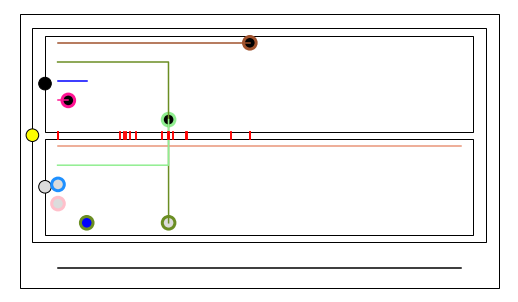

In [3]:
Nsys = 1

for i in range(Nsys):
    run_sim(filestem=f'test/test{i:04d}')

In [4]:
  
def setup_sim_moon(i):

    global glob_archive
    global glob_is_close
    global glob_is_eject
    global glob_is_stop
    global glob_dclo
    global glob_pl_done
    
    print()
    print(f'Simulation {i} with moons:')
    
    globals.glob_archive = dir + f"moons_{i:04d}.bin"
    globals.glob_log = globals.glob_archive[:-3]+'.log'
    globals.glob_is_close = False
    globals.glob_is_eject = False
    globals.glob_is_stop = False
    
    pl_done = (globals.glob_archive in globals.glob_pl_done)

    try:
        sim = rebound.Simulation(globals.glob_archive)
    except:
        print(f'archive file {gloabls.glob_archive} not found')
        return
    else:
#check end state
        if len(sim.particles) == 2:
            print('restored simulation has only one planet')
            print()
            glob_is_eject = True
        if sim.t >= tmax - TINY:
            print(f'restored simulation was stable for {tmax} yrs')
            print()
            glob_is_stop = True
        for p in sim.particles[1:]:
            rh2 = p.d**2 * (p.m/(3*sim.particles[0].m))**(2/3)
            for q in sim.particles[1:]:
                if p.hash.value == q.hash.value:
                    continue
                dx = p.x-q.x
                dy = p.y-q.y
                dz = p.z-q.z
                d2 = dx*dx + dy*dy + dz*dz
                if d2 <= rh2*globals.glob_dclo:
                    globals.glob_is_close = True
                    print('restored simulation is undergoing CE')
                    print()
        if ((not globals.glob_is_eject) and (not globals.glob_is_stop) and 
            (not globals.glob_is_close) and (not pl_done)):
            print('restored simulation needs continuing...')
            run_sim_pl(i)

# if CE, rewind and add moons

        rng = np.random.default_rng()
        
        has_moons = archive in globals.glob_moons_added.keys()
        
        if globals.glob_is_close and not has_moons:
            
            print('rewinding simulation...')
            sim.dt = -sim.dt
            tstart = sim.t - t_rewind
            sim.integrate(tstart)
            
            print('adding moons...')
            sim.dt = -sim.dt
            
            for p in sim.particles[1:]:
                p.r = (((9/4*np.pi)*p.m*u.Msun/(1.8*u.g/u.cm**3))**(1/3)).to_value(u.au)
                print(p.r)
            # moons. Data from JPL horizons 2022-01-26
            Nmoonsppl = 4 #per planet
            amo = (np.array([4.220279893619238E+05,6.712942692154385E+05,1.070941243876099E+06,
                             1.883987339695996E+06]) * u.km).to(u.au)
            emo = np.array([3.779947596328282E-03,9.515599858678114E-03,1.437934948643515E-03,
                            7.429672504931133E-03])
            imo = np.radians([2.233261880507145E+00,2.499911845043659E+00,2.320207222240029E+00,
                              1.964066225350317E+00])
            wmo = np.radians([2.230114025429823E+02,5.871258018281303E+01,3.520404542215327E+02,
                              3.411426411826523E+01]) # arg of peri
            Omo = np.radians([3.367638701787085E+02,3.289828238020597E+02,3.401167587299205E+02,
                              3.370179889677478E+02])
            mamo = np.radians([2.411569358232406E+02,1.160555854430442E+02,1.129206855751383E+02,
                               6.172934365391181E+01])
            name_mo_stem = ['Io','Europa','Ganymede','Callisto']
            Rmo = (np.array([1821.49,1560.8,2631.2,2410.3])*u.km).to(u.au)
            Mmo = (np.array([5959.9155,3202.7121,9887.8328,
                             7179.2834])*u.km**3/u.s**2 / c.G).to(u.Msun) #JPL gives product GM

            Omo_offset = np.radians(rng.uniform(0,360,2)) #we rotate Omega for all moons in the same moon system by the same amount
            name_moons = [[m+str(i+1) for m in name_mo_stem] for i in range(Npl)]

            for i in range(Npl):
                for j in range(Nmoonsppl):
                    sim.add(a=amo[j].to_value(u.au),e=emo[j],inc=imo[j],omega=wmo[j],Omega=Omo[j]+Omo_offset[i],
                            M=mamo[j],m=Mmo[j].to_value(u.Msun),r=Rmo[j].to_value(u.au),
                            primary=sim.particles[name_pl[i]],hash=name_moons[i][j])

            sim.move_to_com()
            
            # save a snapshot
            sim.simulationarchive_snapshot(globals.glob_archive)
            
            with open('moons_added.txt','a') as f:
                f.write(f'{globals.glob_archive} {sim.t}\n')
            
        else:
            print('No close encounter: passing to next simulation')
            return
        
#        # automate archive
#        sim.automateSimulationArchive(glob_archive, interval=1.,deletefile=False)
#        
#        tend = glob_moons_added[glob_archive] + tmoons
#        print('integrating with moons...')
#        clock_t0 = time.time()
#        sim_t0 = sim.t
#        sim.integrate(tend)
#        sim_t1 = sim.t
#        clock_t1 = time.time()
#        print(f'{sim_t1-sim_t0} years took {clock_t1-clock_t0} seconds')
#        
#        # final snapshot
#        sim.simulationarchive_snapshot(glob_archive)
            
        return

In [5]:
# can we restore an existing sim?
try:
    sim = rebound.Simulation()
except:
    

globals.glob_pl_done = []
globals.glob_moons_added = {}

try:
    with open('planets_done.txt','r') as f:
        lines = f.readlines()
except:
    print('No sims with pre-moon run completed')
else:
    for l in lines:
        globals.glob_pl_done.append(l.strip())

try:
    with open('moons_added.txt','r') as f:
        lines = f.readlines()
except:
    print('No simulations with moons yet added')
else:    
    for l in lines:
        s = l.split()
        globals.glob_moons_added[s[0]] = float(s[1])


for i in range(Nsys):
    archive = dir + f"moons_{i:04d}.bin"

# if not in list of sims with planet bit finished, must continue 
    if not (archive in globals.glob_pl_done):
        run_sim_pl(i)

    setup_sim_moon(i)

IndentationError: expected an indented block (3512627896.py, line 7)

In [ ]:
try:
    with open('moons_added.txt','r') as f:
        lines = f.readlines()

    for l in lines:
        s = l.split()
        glob_moons_added[s[0]] = float(s[1])
except:
    print('no simulations with moons yet added')
else:
    for s in glob_moons_added.keys():

#        if s == 'test/moons_0000.bin':
#            continue # this one has ground to a halt
        
        glob_log = s[:-3]+'log'
        
        glob_darr = [[[9999.9,9999.9,9999.9],[9999.9,9999.9,9999.9]],
                     [[9999.9,9999.9,9999.9],[9999.9,9999.9,9999.9]]]
        
        archive = s
        sim = rebound.Simulation(s)
        glob_planets = [n for n in name_pl]
        sim_hashes = [p.hash.value for p in sim.particles]
        glob_npl = sum([rebound.hash(p).value in sim_hashes for p in glob_planets])# this and the heartbeat needs to be done more carefully in case planets change their order

        tend = glob_moons_added[s] + t_moons
        sim.heartbeat = heartbeat
        sim.collision = "line"
        sim.collision_resolve = logged_merge
        sim.track_energy_offset = 0

        sim.automateSimulationArchive(s,interval=1.,deletefile=False)
        
        sim_t0 = sim.t
        clock_t0 = time.time()

        print(f'Simulation restored at {sim.t} years:    {s}')
        print()
        
        with open(glob_log,'a') as f:
            print(f'Simulation restored at {sim.t} years:    {s}',file=f)
            print('',file=f)

        
        while sim.t < tend:
            try:
                sim.integrate(tend)
            except rebound.Escape as error:
# save at this point
                sim.simulationarchive_snapshot(archive)

                print(error)
                hashes = set()
# Rebound example just allows one body to be removed; might have more    
                for h in name_all:
                    try:
                        p = sim.particles[h]
                        d2 = p.x**2 + p.y**2 + p.z**2
                        if d2 > sim.exit_max_distance**2:
                            hashes.add(h)
                    except:
                        if verbose:
                            print(f'{h} has already been removed')

# Here, we also want to remove any moons bound to a removed planet
                for h in name_all:
                    try:
                        if rebound.hash(find_primary(h,name_pl,sim)) in [ha.value for ha in hashes]:
                            hashes.add(h)
                    except:
                        if verbose:
                            print(f'{h} has already been removed')


                Ein = sim.calculate_energy()

                for h in hashes:
                    print(f'{h} ejected at {sim.t} years')
                    print(sim.particles[h])
                    with open(globals.glob_log,'a') as f:
                        print(f'{h} ejected at {sim.t} years',file=f)
                        print(sim.particles[h],file=f)
                    if h in globals.glob_planets:
                        globals.glob_planets.remove(h)
                        globals.glob_npl = globals.glob_npl-1
                    sim.remove(hash=h)
                sim.move_to_com()    

                Eout = sim.calculate_energy()

#        if sim.track_energy_offset:
                sim.energy_offset += (Ein-Eout)

        sim_t1 = sim.t
        clock_t1 = time.time()
        
        print(f'{sim_t1-sim_t0} years took {clock_t1-clock_t0} seconds')
        print()
        
        with open(glob_log,'a') as f:
            print(f'{sim_t1-sim_t0} years took {clock_t1-clock_t0} seconds',file=f)
            print('',file=f)
        
        for moon in name_all:
            try:
                print(moon+' bound to '+find_primary(moon,name_pl,sim).hash)
                with open(glob_log,'a') as f:
                    print(moon+' bound to '+find_primary(moon,name_pl,sim).hash,file=f)
            except AttributeError:
                print(moon+' was removed')
                with open(glob_log,'a') as f:
                    print(moon+' was removed',file=f)

        print()
        print()
        
        with open(glob_log,'a') as f:
            print('',file=f)
            print('',file=f)

In [5]:
l = 'Added star: EPIC220208795'
print(l.split())

['Added', 'star:', 'EPIC220208795']
